### LightGBM
- XGB와 함께 부스팅 계열 알고리즘에서 인기.
- XGB는 학습 시간이 너무 오래 걸림... GridSearchCV로 하이퍼 파라미터 튜닝해서 그런듯.. 물론 GBM보단 빠름 but 대용량 데이터의 경우 만족할 만한 학습 성능을 기대하려면 많은 CPU core를 가진 시스템에서 높은 병렬도로 학습을 진행해야 함. 즉 컴 사양 후지면 더 오래 걸려서 빡침...

- **장점**: xgb보다 학습에 걸리는 시간이 훨씬 적다. 메모리 사용량도 상대적으로 적다. 그런데 xgb랑 예측 성능에 별다른 차이가 없고 기능상 다양성이 더 많음! 왜냐면 xgb보다 2년 뒤에 만들어진 거라 단점 보완하는 방식으로 개발됐다고 함. 카테고리형 피처의 자동 변환과 최적 분할 수행.
- **단점**: 적은 데이터셋에 적용할 경우 과적합 발생하기 개쉬움.. 일반적으로 10,000 건 이하의 데이터 세트 정도

- 얘도 병렬 컴퓨팅 기능 제공, GPU도 제공

- 일반 GBM 계열의 트리 분할 방법(균형 트리 분할, Level Wise)과 다르게 리프 중심 트리 분할(Leaf Wise) 방식 사용. => 최대 손실 값(max delta loss)을 가지는 리프 노드를 지속적으로 분할. => 트리 깊이 깊어지고 비대치적인 규칙 트리 생성됨. 
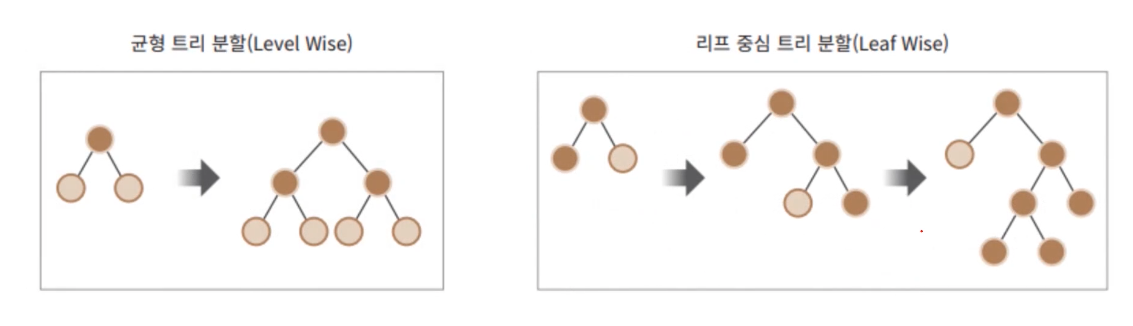
- 균형 트리 분할 방식보다 예측 오류 손실 최소화 가능! 

In [ ]:
import lightgbm

print(lightgbm.__version__)

3.3.5


주요 parameter
- num_iterations (default=100): 크게 지정할수록 예측 성능이 높아질 수 있으나 과적합 위험도 높아짐. 사이킷런 호환 클래스에선 n_estimators
- learning_rate (default=0.1)
- max_depth (default=-1) : 0 미만 값 지정시 깊이에 제한x. lightgbm은 leaf wise 기반이므로 깊이가 다른 트리들과 다르게 깊음.
- min_data_in_leaf (default=20): decision tree의 min_samples_leaf와 같은 역할. 사이킷런에선 min_child_samples. 리프 노드가 되기 위해 최소한으로 필요한 레코드 수, 과적합을 제어하기 위한 파라미터. 
- num_leaves (default=31): 최대 리프 개수
- boosting (default=gbdt) : 부스팅의 트리를 생성하는 알고리즘
  - gbdt: gradietn boosting decision tree
  - rf: random forest
- bagging_fraction (default=1.0) : 데이터 샘샘플링 비율. 사이킷런 래퍼에선 subsample
- feature_fraction (default=1.0): 개별 트리를 학습할 때마다 무작위로 선택하는 feature의 비율. ㅅㅇㅋㄹ: colsample_bytree
- lambda_l2: L2 regulation. reg_lambda
- lambda_l1: L1 regulation. reg_alpha

- objective (learning task parameter): 최솟값을 가져야 할 손실함수 정의.  


### hyperparameter 튜닝 방안
- num_leaves 개수 중심으로 min_child_samples, max_depth 함께 조정하며 모델의 복잡도 줄이는 것이 기본적.
  - num_leaves:  개수를 높이면 정확도가 높아지지만 깊이가 깊어지고 모델이 복잡도가 커져 과적합 영향도도 커짐
  - min_child_samples: 큰 값으로 설정하면 트리가 깊어지는 것을 방지.
- learning_rate 작게 하면서 n_estimators 크게 하기 (너무 클 경우 과적합 위험 커짐)
- reg_lambda, reg_alpha 같은 regularization 적용하기
- colsample_bytree, subsample 적용해서 학습에 사용할 feature 개수개수나 data sampling record 개수 줄이

### LightGBM 적용 – 위스콘신 Breast Cancer Prediction

In [ ]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정.
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9877


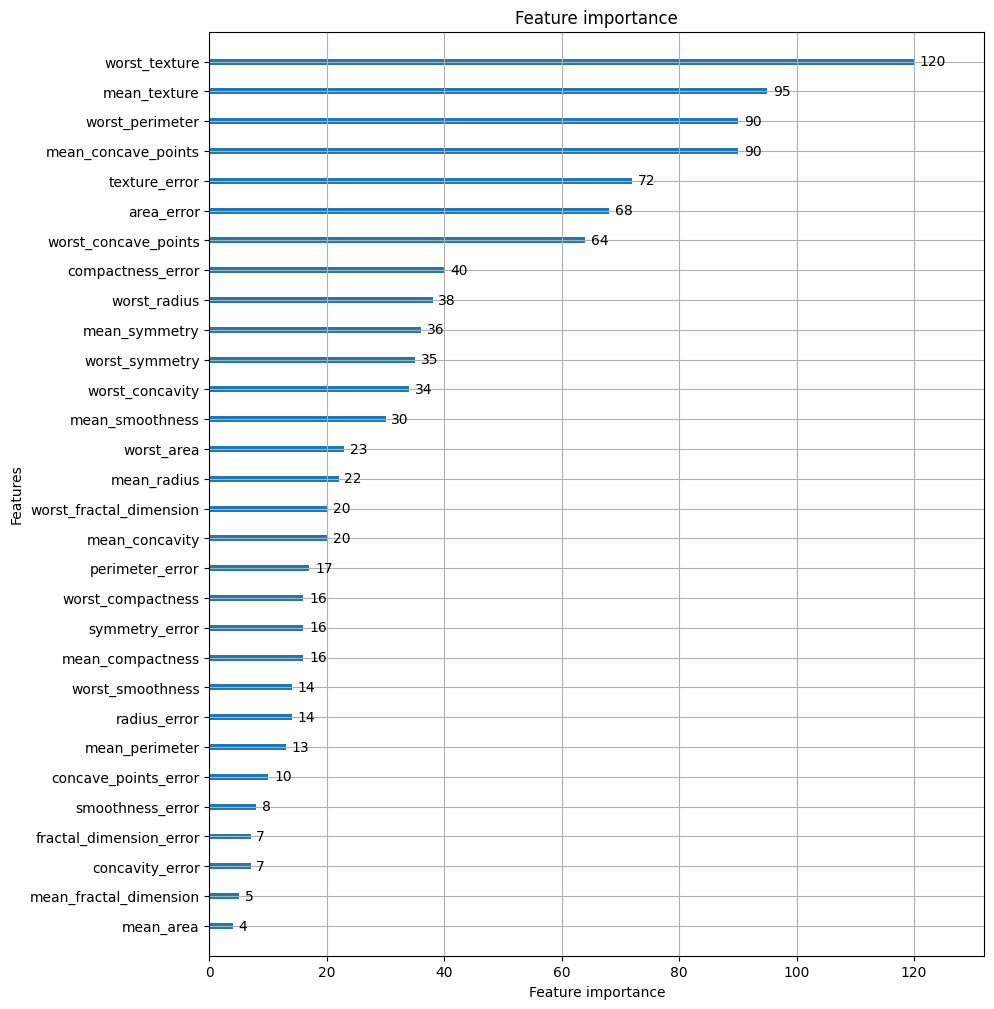

In [ ]:
# plot_importance( )를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)
plt.savefig('lightgbm_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')